# Taking into account the covariance of errors in PSFMag and KronMag

In calculation of the error in psfKronRatio I have ignored the covariance in PSFMagErr and KronMagErr. 
To take into account it I assume the correlation coefficient $\rho_{12,i}$ in PSFMagErr ($\sigma_{1,i}$) and KronMagErr ($\sigma_{2,i}$) is not change in all measurement: 

$\rho_{12,i} \sim \overline{\rho_{12}} = \sigma_{12,i}/\sigma_{1,i}\sigma_{2,i} $ 

where $\sigma_{12,i}$ is the covariance in PSFMagErr and KronMagErr, and we can get approximate covariance in each measurement

$\sigma_{12,i} \sim \overline{\rho_{12}}\sigma_{1,i}\sigma_{2,i}$. 

I think it is not bad approximation because each measurement is derived from same instruments/methods. 

$\overline{\rho_{12}}$ can be calculated directly from $\sigma_{1}$ and $\sigma_{2}$. 


In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
%matplotlib inline
hst_ps1 = pd.read_csv('HST_PS1_stack_tachibana.csv')
cat = hst_ps1.drop_duplicates(['objID'])
del hst_ps1

In [2]:
star, galaxy = cat.MU_CLASS == 2, cat.MU_CLASS == 1
mag_mask = cat.MAG_AUTO <= 24.5
star = star&mag_mask; galaxy = galaxy&mag_mask

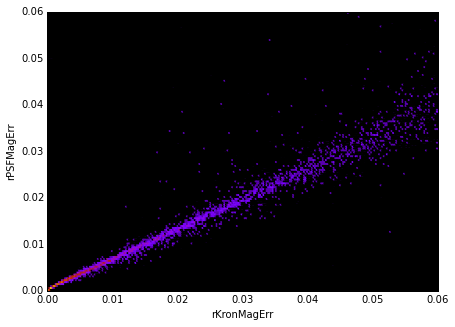

In [3]:
plt.figure(figsize=(7,5))
plt.hexbin(cat.rKronMagErr[star], cat.rPSFMagErr[star], extent=[0,0.06, 0,0.06], bins='log', cmap='gnuplot', gridsize=250)
plt.xlabel('rKronMagErr'); plt.ylabel('rPSFMagErr')
plt.show();plt.close()

Correlation coefficient between rKronMagErr and rPSFMagErr is $\sim 0.9$. 

Since we already know that LogPsfKronRatio (= [KronMag - PSFMag]/2.5, $R$ hereafter) gives the highest accuracy for HSTxPS1 data, I calculate it by just substracting PSFMag from KronMag. 

Additionally, I corrected the error calculation in (KronMag $-$ PSFMag) by taking into account the covariance in KronMagErr ($\sigma_{1}$) and PSFMagErr ($\sigma_{2}$): 

$\sigma_{R,i}^2 = [\partial R/\partial x_1]_{x_{1,i}}^2 \sigma_{1,i}^2 +[ \partial R/\partial x_2]_{x_{2,i}}^2 \sigma_{2,i}^2 +
2[\partial R/\partial x_1]_{x_{1,i}}[ \partial R/\partial x_2]_{x_{2,i}}\overline{\rho_{12}}\sigma_{1,i}\sigma_{2,i}$

where $\overline{\rho_{12}}$ is the correlation coefficient in $\sigma_1$ and $\sigma_2$.

In [4]:
def calc_psfKronRatio(catalog, correct_cov=True):
    filter_name =  ['g', 'r', 'i', 'z', 'y']
    psfmag_name = 'PSFMag'
    kronmag_name = 'KronMag'
    psfmagerr_name = 'PSFMagErr'
    kronmagerr_name = 'KronMagErr'
    psfmag_list = []
    kronmag_list = []
    psfmagerr_list = []
    kronmagerr_list = []
    for fil in filter_name:
        psfmag_list.append(fil+psfmag_name)
        kronmag_list.append(fil+kronmag_name)
        psfmagerr_list.append(fil+psfmagerr_name)
        kronmagerr_list.append(fil+kronmagerr_name)
    mag_list = psfmag_list + kronmag_list + psfmagerr_list + kronmagerr_list
    PS_mag = cat[mag_list]
    weight_norm = np.zeros(len(PS_mag))
    det_num = np.zeros(len(PS_mag))
    mean_mag_diff_w =np.zeros(len(PS_mag))
    mean_mag_differr_w =np.zeros(len(PS_mag))

    for fil in filter_name:
        psf_col_name = fil + psfmag_name
        kron_col_name = fil + kronmag_name
        psferr_col_name = fil + psfmagerr_name
        kronerr_col_name = fil + kronmagerr_name
        
        det_mask = (PS_mag[psf_col_name].values != -999)&(PS_mag[kron_col_name].values != -999)
        
        PsfKronDiffMag = np.add(-PS_mag[psf_col_name].values, PS_mag[kron_col_name].values,
                                                  out = np.zeros_like(mean_mag_diff_w),
                                                  where = det_mask)/2.5
        
        if correct_cov:
            ErrCorCoef = np.corrcoef(PS_mag[psferr_col_name][det_mask].values, 
                                    PS_mag[kronerr_col_name][det_mask].values)[0,1]
        else: 
            ErrCorCoef = 0                
        
        PsfKronDiffMagErr = np.sqrt( PS_mag[psferr_col_name].values**2 +
                                   PS_mag[kronerr_col_name].values**2 -
                                   2*ErrCorCoef*PS_mag[psferr_col_name].values*PS_mag[kronerr_col_name].values)

        weight = np.divide(1, PsfKronDiffMagErr**2, 
                                                  out = np.zeros_like(mean_mag_diff_w), 
                                                  where = det_mask)

        PsfKronDiffMag_w = np.multiply(PsfKronDiffMag, weight, 
                                                  out = np.zeros_like(mean_mag_diff_w), 
                                                  where = det_mask)

        PsfKronDiffMagErr_w = np.multiply(PsfKronDiffMagErr, weight, 
                                                  out = np.zeros_like(mean_mag_diff_w), 
                                                  where = det_mask)

        mean_mag_diff_w += PsfKronDiffMag_w
        mean_mag_differr_w += PsfKronDiffMagErr_w
        weight_norm += weight
        det_num += det_mask.astype(int)

    mask = (mean_mag_diff_w != 0)&(weight_norm != 0)
    mean_mag_diff = np.divide(mean_mag_diff_w, weight_norm, 
                             out = np.zeros_like(mean_mag_diff_w), 
                             where = mask)
    mean_mag_differr = np.divide(mean_mag_differr_w, weight_norm*np.sqrt(det_num), 
                             out = np.zeros_like(mean_mag_diff_w), 
                             where = mask)
    
    diff_kwargs = {'mean_psfKronDiff' : mean_mag_diff}
    differr_kwargs = {'mean_psfKronDifferr' : mean_mag_differr}
    PS_mag = PS_mag.assign(**diff_kwargs); PS_mag = PS_mag.assign(**differr_kwargs)
    return PS_mag

In [5]:
PS_mag0 = calc_psfKronRatio(cat, correct_cov=True)
PS_mag1 = calc_psfKronRatio(cat, correct_cov=False)
rdet_mask = (PS_mag0.rKronMag!=-999)&(PS_mag0.mean_psfKronDiff!=0)&(PS_mag0.mean_psfKronDiff!=0)
star = star&rdet_mask; galaxy=galaxy&rdet_mask

/Users/tachibana/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


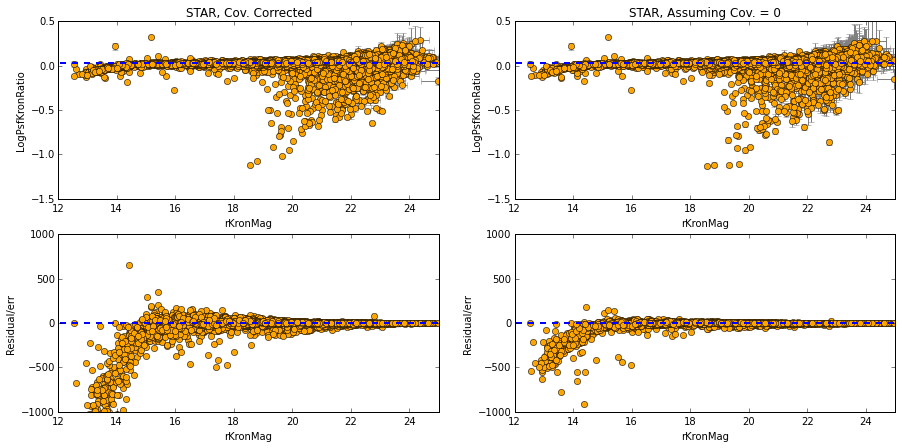

In [6]:
br_mask = (PS_mag0.rKronMag>16)&(PS_mag0.rKronMag<18)
err0 = PS_mag0.mean_psfKronDifferr[star]
err1 = PS_mag1.mean_psfKronDifferr[star]
weight_mean0 = np.average(PS_mag0.mean_psfKronDiff[star&br_mask], 
                         weights=1/ PS_mag0.mean_psfKronDifferr[star&br_mask]**2)
weight_mean1 = np.average(PS_mag1.mean_psfKronDiff[star&br_mask], 
                         weights=1/ PS_mag1.mean_psfKronDifferr[star&br_mask]**2)

plt.figure(figsize=(15, 7))
plt.subplot(2,2,1)
plt.errorbar(PS_mag0.rKronMag[star], PS_mag0.mean_psfKronDiff[star], 
             fmt='o',  xerr=PS_mag0.rKronMagErr[star], yerr= err0,  
            ecolor='grey', color="orange")
plt.plot([10, 30], [weight_mean0, weight_mean0], '--', lw=2,  color='blue')
plt.xlim(12,25); plt.ylim(-1.5,0.5)
plt.title('STAR, Cov. Corrected')
plt.xlabel('rKronMag'); plt.ylabel('LogPsfKronRatio')
plt.subplot(2,2,3)
plt.errorbar(PS_mag0.rKronMag[star], (PS_mag0.mean_psfKronDiff[star] - weight_mean0)/err0, 
            fmt='o', xerr=PS_mag0.rKronMagErr[star], yerr=1, ecolor='grey', color="orange")
plt.plot([10, 30], [0,0], '--', lw=2,  color='blue')
plt.xlabel('rKronMag'); plt.ylabel('Residual/err')
plt.xlim(12,25); plt.ylim(-1000,1000)

plt.subplot(2,2,2)
plt.errorbar(PS_mag1.rKronMag[star], PS_mag1.mean_psfKronDiff[star], 
             fmt='o',  xerr=PS_mag1.rKronMagErr[star], yerr= err1,  
            ecolor='grey', color="orange")
plt.title('STAR, Assuming Cov. = 0')
plt.xlabel('rKronMag'); plt.ylabel('LogPsfKronRatio')
plt.plot([10, 30], [weight_mean1, weight_mean1], '--', lw=2,  color='blue')
plt.xlim(12,25); plt.ylim(-1.5,0.5)
plt.subplot(2,2,4)
plt.errorbar(PS_mag1.rKronMag[star], (PS_mag1.mean_psfKronDiff[star] - weight_mean1)/err1, 
            fmt='o', xerr=PS_mag1.rKronMagErr[star], yerr=1, ecolor='grey', color="orange")
plt.plot([10, 30], [0,0], '--', lw=2,  color='blue')
plt.xlabel('rKronMag'); plt.ylabel('Residual/err')
plt.xlim(12,25); plt.ylim(-1000,1000)
plt.show()

The upper left figure shows the LogPsfKronRatio vs. rKronRatio corrected by taking into account the covariance while the upper right figure is that before corrected (assuming covariance = 0). Taking into account the covarinace in the error of brightness, the error in LogPsfKronRatio becomes smaller (it is because $[\partial R/\partial x_1][ \partial R/\partial x_2]\rho_{12} = -\rho_{12}$ and $\rho_{12}>0$). 
The blue line shows the average of LogPsfRatio between $16 < rKronMag < 18$. 

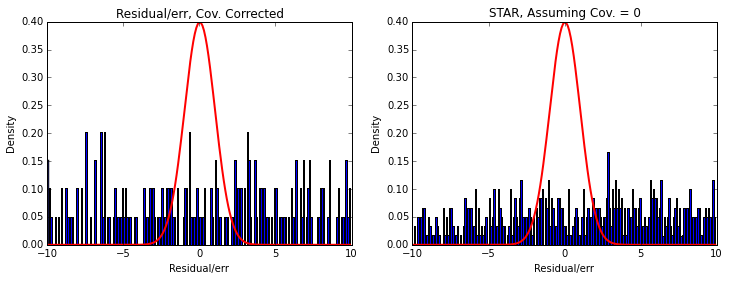

In [7]:
sys_err = 0

bins = np.arange(-10, 10, 0.1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
err0 = np.sqrt(PS_mag0.mean_psfKronDifferr[star&br_mask&rdet_mask]**2 + sys_err**2)
plt.hist(np.array((PS_mag0.mean_psfKronDiff[star&br_mask&rdet_mask] - weight_mean0)/err0), normed=True, 
         bins=bins)
plt.plot(bins, 1/(np.sqrt(2 * np.pi)) *
         np.exp( - (bins - weight_mean0)**2 / (2) ),
         linewidth=2, color='r')
plt.title('Residual/err, Cov. Corrected')
plt.ylabel('Density'); plt.xlabel('Residual/err')

plt.subplot(1,2,2)
err1 = np.sqrt(PS_mag1.mean_psfKronDifferr[star&br_mask&rdet_mask]**2 + sys_err**2)
plt.hist(np.array((PS_mag1.mean_psfKronDiff[star&br_mask&rdet_mask] - weight_mean1)/err1), normed=True,
         bins=bins)
plt.plot(bins, 1/(np.sqrt(2 * np.pi)) *
         np.exp( - (bins - weight_mean1)**2 / (2) ),
         linewidth=2, color='r')
plt.title('STAR, Assuming Cov. = 0')
plt.ylabel('Density'); plt.xlabel('Residual/err')
plt.show()

The figures above are the distribution of the residual/err of the data between $16 < rKronMag < 18$. 
The residual/err distribution should be a normal distribution, however it is quite different from it. 
This is because the systematic error is not negligible compared to the statistical uncertainties of magnitude (PSFMag and KronMag) in this region. 

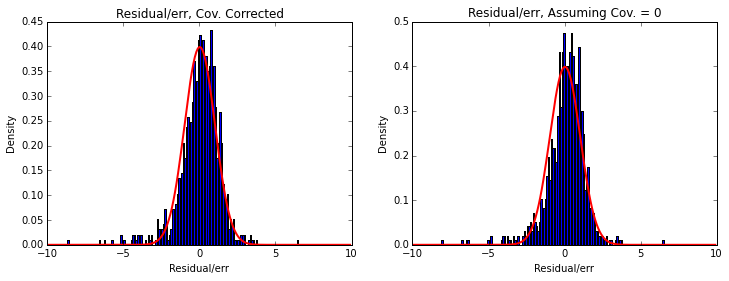

In [8]:
sys_err = 0.01

bins = np.arange(-10, 10, 0.1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
err0 = np.sqrt(PS_mag0.mean_psfKronDifferr[star&br_mask&rdet_mask]**2 + sys_err**2)
plt.hist(np.array((PS_mag0.mean_psfKronDiff[star&br_mask&rdet_mask] - weight_mean0)/err0), normed=True, 
         bins=bins)
plt.plot(bins, 1/(np.sqrt(2 * np.pi)) *
         np.exp( - (bins - weight_mean0)**2 / (2) ),
         linewidth=2, color='r')
plt.title('Residual/err, Cov. Corrected')
plt.ylabel('Density'); plt.xlabel('Residual/err')

plt.subplot(1,2,2)
err1 = np.sqrt(PS_mag1.mean_psfKronDifferr[star&br_mask&rdet_mask]**2 + sys_err**2)
plt.hist(np.array((PS_mag1.mean_psfKronDiff[star&br_mask&rdet_mask] - weight_mean1)/err1), normed=True,
         bins=bins)
plt.plot(bins, 1/(np.sqrt(2 * np.pi)) *
         np.exp( - (bins - weight_mean1)**2 / (2) ),
         linewidth=2, color='r')
plt.title('Residual/err, Assuming Cov. = 0')
plt.ylabel('Density'); plt.xlabel('Residual/err')
plt.show()
plt.show()

If I add quadratically 0.01 to the statistical error in magnitude as a systematic error, the distribution of residual/err becomes close to the normal distibution. 
The left figure which is covariance corrected seems more similar to a normal distribution. 